## basic 2 key factors affecting emissions

This notebook is used for demonstrating the key factors which affect inland shipping emissions. 
<br>The key factors include:
- vessel sailing speed,
- water depth, 
- vessel engine age
- current speed and direction. 

### *Learning objectives*

*Real world facts understanding*
- *the students should be clear about the environmental factors and vessel factors (design, and operation) affecting emissions.*
- *How could the above two kinds of factors be adjusted in real world situation to reduce emissions*
*Practical coding skills*
- *the student should be able to adjust the factors input and extract corresponding resistance, power, energy, emissions from OpenTNSim log*


#### Assignment:
With fixed environmental factors (h = 4 m, waterway width =150 m, Uc = 1 m/s, waterway length = 100 km), quantify the total emissions (CO2, PM10, NOx) for the 4 situations:
- sailing upstream: M8 vessel, engine construction year = 1970, Vg= 12 km/h
- sailing upstream: M8 vessel, engine construction year = 1970, Vg= 12 km/h
- sailing downstream: M10 vessel, engine construction year = 1970, Vg = 16 km/h
- sailing downstream: M10 vessel, engine construction year = 2020, Vg = 16 km/h

Analysis the emissions results in the aspects of emission types, vessel types, sailing speed, engine construction year.

---------------------

### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import logging
import datetime, time
import platform
import itertools
# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSim
import opentnsim

# Used for mathematical functions
import math             
import tqdm
# Used for making the graph to visualize our problem
import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
logging.basicConfig(level=logging.INFO)# turn off all the debug messages


### Vessels 
<br> - M8 vessel is used for demonstrating water depth and engine age influence
<br> - M6, M8, M10 are used for demonstrating vessel type influence
<br> - M12_up and M12_down are used for demonstrating current influence
<br>

In [2]:
# Create a dict with all important settings

data_vessel_M6 = {
    "env": None,
    "name": 'M6',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":None,
    "use_V_g_profile":False,
    "type": None,
    "B": 9.5,
    "L": 85,
    "T": 2.9,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":780,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 2000, # the engine construction year is only used for diesel use and emissions quantification
}             



In [3]:
# Create a dict with all important settings

data_vessel_M8 = {
    "env": None,
    "name": 'M8',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":None,
    "use_V_g_profile":False,
    "type": None,
    "B": 11.45,
    "L": 110,
    "T": 3,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 3.0 ,
    "C_B":0.85, 
    "C_year": 1990, # the engine construction year is only used for diesel use and emissions quantification
}             



In [4]:
# vessel dict with all important settings

data_vessel_M10 = {
    "env": None,
    "name": 'M10',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":None,
    "use_V_g_profile":False,
    "type": None,
    "B": 13.5,
    "L": 110,
    "T": 3,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":2400,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 3.0 ,
    "C_B":0.85, 
    "C_year": 1990, # the engine construction year is only used for diesel use and emissions quantification
}             



In [5]:
# vessel dict with all important settings

data_vessel_M12_up = {
    "env": None,
    "name": 'M12_up',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 17,
    "L": 135,
    "T": 4,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":3000,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 3.0 ,
    "C_B":0.85, 
    "C_year": 2000, # the engine construction year is only used for diesel use and emissions quantification
}             


In [6]:

data_vessel_M12_down = {
    "env": None,
    "name": 'M12_down',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 17,
    "L": 135,
    "T": 4,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":3000,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 3.0 ,
    "C_B":0.85, 
    "C_year": 2000, # the engine construction year is only used for diesel use and emissions quantification
}             



### Make your preferred class out of available mix-ins.

In [7]:

TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

---------------------------

### Input preparation 
for analysing water depth, engine age and vessel type influence to emissions

In [8]:
V_s = np.linspace(0.1, 6, 61)          # ship sailing speeds to water, (m/s)
h_0 = [10, 7.5, 5, 3.5]                 # water depths,(m)
C_year = [1970, 1980, 1990, 2000, 2010, 2020]   # engine construction years

In [9]:
# prepare the work to be done
# create a list of all combinations
work = list(itertools.product(C_year, h_0, V_s))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"C_year": item[0], "h_0": item[1], "V_s": item[2]}
    rows.append(row)

# these are all the simulations that we want to run
# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)
work_df.tail()

,C_year,h_0,V_s
1459,2020,3.5,5.606667
1460,2020,3.5,5.705000
1461,2020,3.5,5.803333
1462,2020,3.5,5.901667
1463,2020,3.5,6.000000


### Calculation
for analysing water depth, engine age and vessel type influence to emissions

In [10]:
results = []

for i, row in tqdm.tqdm(work_df.iterrows()):

    C_year = row['C_year']
    data_vessel_M6_i = data_vessel_M6.copy()
    data_vessel_M6_i['C_year'] = C_year
    vessel_M6 = TransportResource(**data_vessel_M6_i)
    
    data_vessel_M8_i = data_vessel_M8.copy()
    vessel_M8 = TransportResource(**data_vessel_M8_i)

    data_vessel_M10_i = data_vessel_M10.copy()
    vessel_M10 = TransportResource(**data_vessel_M10_i)
    
    V_s = row['V_s']
    h_0 = row['h_0']
    vessel_M6.calculate_properties() 
    R_T_M6 = vessel_M6.calculate_total_resistance(V_s, h_0)
    (eta_D_M6, P_d_M6, P_propulsion_M6, P_tot_M6, P_given_M6) = vessel_M6.calculate_total_power_required(V_s, h_0)
    vessel_M6.emission_factors_general()
    vessel_M6.correction_factors(V_s, h_0)
    vessel_M6.calculate_emission_factors_total(V_s, h_0)
    [emission_g_m_CO2_M6,emission_g_m_PM10_M6,emission_g_m_NOX_M6] = vessel_M6.calculate_emission_rates_g_m(V_s)

    vessel_M8.calculate_properties() 
    vessel_M8.calculate_total_resistance(V_s, h_0)
    (eta_D_M8, P_d_M8, P_propulsion_M8, P_tot_M8, P_given_M8) = vessel_M8.calculate_total_power_required(V_s, h_0)
    vessel_M8.emission_factors_general()
    vessel_M8.correction_factors(V_s, h_0)
    vessel_M8.calculate_emission_factors_total(V_s, h_0)
    [emission_g_m_CO2_M8,emission_g_m_PM10_M8,emission_g_m_NOX_M8] = vessel_M8.calculate_emission_rates_g_m(V_s)


    vessel_M10.calculate_properties() 
    vessel_M10.calculate_total_resistance(V_s, h_0)
    (eta_D_M10, P_d_M10, P_propulsion_M10, P_tot_M10, P_given_M10) = vessel_M10.calculate_total_power_required(V_s, h_0)
    vessel_M10.emission_factors_general()
    vessel_M10.correction_factors(V_s, h_0)
    vessel_M10.calculate_emission_factors_total(V_s, h_0)
    [emission_g_m_CO2_M10,emission_g_m_PM10_M10,emission_g_m_NOX_M10] = vessel_M10.calculate_emission_rates_g_m(V_s)
   
    
    result = {}
    result.update(row)

    result['R_T_M6'] = R_T_M6
    result['P_tot_M6'] = P_tot_M6
    result['P_installed_M6'] = vessel_M6.P_installed
    

    result['emission_g_km_CO2_M6'] = emission_g_m_CO2_M6 * 1000
    result['emission_g_km_PM10_M6'] = emission_g_m_PM10_M6 * 1000
    result['emission_g_km_NOX_M6'] = emission_g_m_NOX_M6 * 1000

    result['P_tot_M8'] = P_tot_M6
    result['P_installed_M8'] = vessel_M8.P_installed
    result['emission_g_km_CO2_M8'] = emission_g_m_CO2_M8 * 1000
    result['emission_g_km_PM10_M8'] = emission_g_m_PM10_M8 * 1000
    result['emission_g_km_NOX_M8'] = emission_g_m_NOX_M8 / 1000
    
    result['P_tot_M10'] = P_tot_M10
    result['P_installed_M10'] = vessel_M10.P_installed
    result['emission_g_km_CO2_M10'] = emission_g_m_CO2_M10 * 1000
    result['emission_g_km_PM10_M10'] = emission_g_m_PM10_M10 * 1000
    result['emission_g_km_NOX_M10'] = emission_g_m_NOX_M10 * 1000
    
    
    results.append(result)

1464it [00:45, 31.83it/s]


### Get calculation results

In [11]:
plot_df = pd.DataFrame(results)

# convert from meters per second to km per hour
ms_to_kmh = 3.6
plot_df['V_s_km'] = plot_df['V_s'] * ms_to_kmh

# plot_df.head(100)
plot_df

,C_year,h_0,V_s,R_T_M6,P_tot_M6,P_installed_M6,emission_g_km_CO2_M6,emission_g_km_PM10_M6,emission_g_km_NOX_M6,P_tot_M8,P_installed_M8,emission_g_km_CO2_M8,emission_g_km_PM10_M8,emission_g_km_NOX_M8,P_tot_M10,P_installed_M10,emission_g_km_CO2_M10,emission_g_km_PM10_M10,emission_g_km_NOX_M10,V_s_km
0,1970.0,10.0,0.100000,0.033621,62.407001,780,160672.124655,203.223676,2875.549933,62.407001,1750,332812.639343,303.962613,0.006033,192.011077,2400,456423.890516,416.861431,8274.153694,0.360
1,1970.0,10.0,0.198333,0.120512,62.449774,780,81063.778073,102.489328,1450.343177,62.449774,1750,167871.691828,153.280179,0.003043,192.078747,2400,230206.560550,210.207156,4172.561684,0.714
2,1970.0,10.0,0.296667,0.255906,62.558098,780,54283.407952,68.557927,970.432338,62.558098,1750,112342.267903,102.510495,0.002035,192.250123,2400,154032.275653,140.573842,2790.738161,1.068
3,1970.0,10.0,0.395000,0.437464,62.759847,780,40894.394780,51.545861,729.990212,62.759847,1750,84533.879522,77.041993,0.001530,192.569318,2400,115868.706509,105.637250,2097.694737,1.422
4,1970.0,10.0,0.493333,0.663578,63.081727,780,32902.214020,41.340718,585.931740,63.081727,1750,67886.888771,61.750124,0.001227,193.078613,2400,93005.733276,84.655377,1681.731700,1.776
5,1970.0,10.0,0.591667,0.932997,63.549570,780,27626.598384,34.551710,490.280820,63.549570,1750,56849.826804,51.564354,0.001025,193.818925,2400,77830.109037,70.674652,1404.830915,2.130
6,1970.0,10.0,0.690000,1.244686,64.188491,780,23914.844212,29.719805,422.396331,64.188491,1750,49035.464298,44.303904,0.000882,194.830056,2400,67068.093156,60.704688,1207.639183,2.484
7,1970.0,10.0,0.788333,1.597750,65.022989,780,21189.112747,26.112607,371.920512,65.022989,1750,43247.366027,38.875293,0.000775,196.150859,2400,59079.023603,53.246366,1060.404236,2.838
8,1970.0,10.0,0.886667,1.991395,66.077018,780,19127.659077,23.321103,333.073234,66.077018,1750,38819.589867,34.669238,0.000692,197.819337,2400,52949.768485,47.464729,946.558142,3.192
9,1970.0,10.0,0.985000,2.424904,67.374033,780,17536.993515,21.097912,302.363525,67.374033,1750,35351.888575,31.318776,0.000626,199.872732,2400,48131.579053,42.857292,856.133677,3.546


### Water depth influence 

(array([   0.,  500., 1000., 1500., 2000., 2500., 3000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

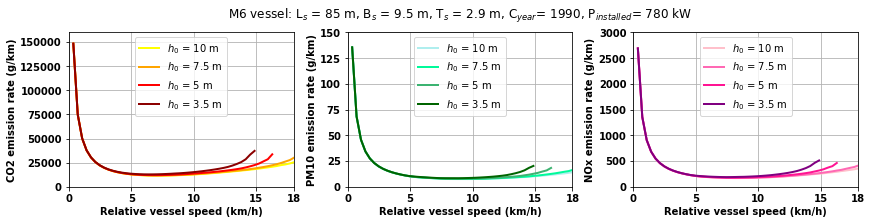

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3),constrained_layout=True)
fontsize=10


ax=plt.subplot(131)
# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2_M6'], 'yellow',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 7.5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2_M6'], 'orange',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2_M6'], 'red',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 3.5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2_M6'], 'darkred',linewidth = 2.0)

plt.legend(['$h_0$ = 10 m', '$h_0$ = 7.5 m', '$h_0$ = 5 m', '$h_0$ = 3.5 m'],loc='upper center')
plt.grid()
plt.xlim(0, 18)  #  set vessel speed range (km/h) for inland shipping
plt.ylim(0, 160000)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('CO2 emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')


ax=plt.subplot(132)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10_M6'], 'paleturquoise',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 7.5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10_M6'], 'mediumspringgreen',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10_M6'], 'mediumseagreen',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 3.5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10_M6'], 'darkgreen',linewidth = 2.0)

plt.legend(['$h_0$ = 10 m', '$h_0$ = 7.5 m', '$h_0$ = 5 m', '$h_0$ = 3.5 m'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 150)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('PM10 emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')
plt.title('M6 vessel: L$_s$ = 85 m, B$_s$ = 9.5 m, T$_s$ = 2.9 m, C$_{year}$= 1990, P$_{installed}$= 780 kW',y=1.05)

ax=plt.subplot(133)
# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX_M6'], 'pink',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 7.5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX_M6'], 'hotpink',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX_M6'], 'deeppink',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 3.5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX_M6'], 'purple',linewidth = 2.0)

plt.legend(['$h_0$ = 10 m', '$h_0$ = 7.5 m', '$h_0$ = 5 m', '$h_0$ = 3.5 m'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 3000)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10, weight='bold',labelpad=3)
plt.ylabel('NOx emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')



(array([  0., 100., 200., 300., 400., 500., 600.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

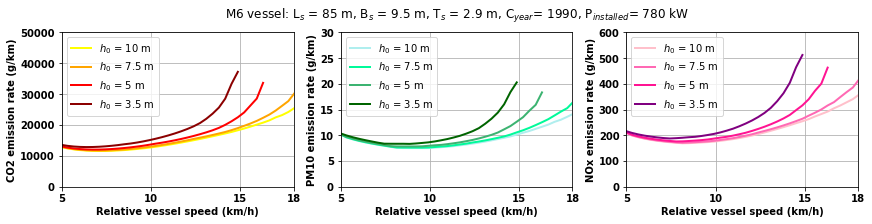

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3),constrained_layout=True)
fontsize=10


ax=plt.subplot(131)
# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2_M6'], 'yellow',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 7.5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2_M6'], 'orange',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2_M6'], 'red',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 3.5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2_M6'], 'darkred',linewidth = 2.0)

plt.legend(['$h_0$ = 10 m', '$h_0$ = 7.5 m', '$h_0$ = 5 m', '$h_0$ = 3.5 m'],loc='upper left')
plt.grid()
plt.xlim(5, 18)  #  set vessel speed range (km/h) for inland shipping
plt.ylim(0, 50000)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('CO2 emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')


ax=plt.subplot(132)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10_M6'], 'paleturquoise',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 7.5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10_M6'], 'mediumspringgreen',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10_M6'], 'mediumseagreen',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 3.5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10_M6'], 'darkgreen',linewidth = 2.0)

plt.legend(['$h_0$ = 10 m', '$h_0$ = 7.5 m', '$h_0$ = 5 m', '$h_0$ = 3.5 m'],loc='upper left')
plt.grid()
plt.xlim(5, 18)
plt.ylim(0, 30)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('PM10 emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')
plt.title('M6 vessel: L$_s$ = 85 m, B$_s$ = 9.5 m, T$_s$ = 2.9 m, C$_{year}$= 1990, P$_{installed}$= 780 kW',y=1.05)

ax=plt.subplot(133)
# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX_M6'], 'pink',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 7.5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX_M6'], 'hotpink',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX_M6'], 'deeppink',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 3.5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX_M6'], 'purple',linewidth = 2.0)

plt.legend(['$h_0$ = 10 m', '$h_0$ = 7.5 m', '$h_0$ = 5 m', '$h_0$ = 3.5 m'],loc='upper left')
plt.grid()
plt.xlim(5, 18)
plt.ylim(0, 600)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10, weight='bold',labelpad=3)
plt.ylabel('NOx emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')



### Engine age influence

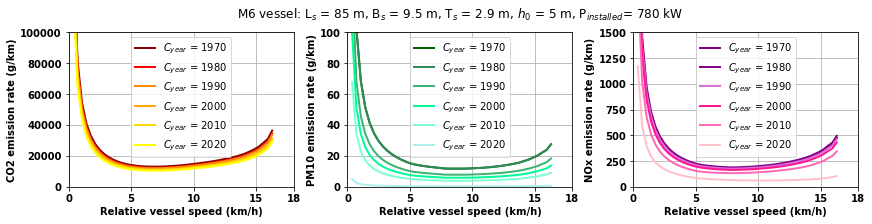

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3),constrained_layout=True)
fontsize=10


ax=plt.subplot(131)
# Select data for this subplot/line
selected = plot_df.query('C_year == 1970 and h_0 == 5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2_M6'], 'darkred',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1980 and h_0 == 5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2_M6'], 'red',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2_M6'], 'darkorange',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 2000 and h_0 == 5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2_M6'], 'orange',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 2010 and h_0 == 5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2_M6'], 'gold',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 2020 and h_0 == 5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2_M6'], 'yellow',linewidth = 2.0)

plt.legend(['$C_{year}$ = 1970', '$C_{year}$ = 1980', '$C_{year}$ = 1990', '$C_{year}$ = 2000', 
            '$C_{year}$ = 2010', '$C_{year}$ = 2020'],loc='upper center')
plt.grid()
plt.xlim(0, 18)  #  set vessel speed range (km/h) for inland shipping
plt.ylim(0, 100000)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('CO2 emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')

ax=plt.subplot(132)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1970 and h_0 == 5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10_M6'], 'darkgreen',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1980 and h_0 == 5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10_M6'], 'seagreen',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10_M6'], 'mediumseagreen',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 2000 and h_0 == 5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10_M6'], 'mediumspringgreen',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 2010 and h_0 == 5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10_M6'], 'aquamarine',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 2020 and h_0 == 5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10_M6'], 'paleturquoise',linewidth = 2.0)

plt.legend(['$C_{year}$ = 1970', '$C_{year}$ = 1980', '$C_{year}$ = 1990', '$C_{year}$ = 2000', 
            '$C_{year}$ = 2010', '$C_{year}$ = 2020'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 100)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('PM10 emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')
plt.title('M6 vessel: L$_s$ = 85 m, B$_s$ = 9.5 m, T$_s$ = 2.9 m, $h_0$ = 5 m, P$_{installed}$= 780 kW',y=1.05)

ax=plt.subplot(133)
# Select data for this subplot/line
selected = plot_df.query('C_year == 1970 and h_0 == 5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX_M6'], 'purple',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1980 and h_0 == 5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX_M6'], 'darkmagenta',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX_M6'], 'orchid',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 2000 and h_0 == 5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX_M6'], 'deeppink',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 2010 and h_0 == 5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX_M6'], 'hotpink',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 2020 and h_0 == 5 and P_tot_M6 < P_installed_M6')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX_M6'], 'pink',linewidth = 2.0)

plt.legend(['$C_{year}$ = 1970', '$C_{year}$ = 1980', '$C_{year}$ = 1990', '$C_{year}$ = 2000', 
            '$C_{year}$ = 2010', '$C_{year}$ = 2020'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 1500)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10, weight='bold',labelpad=3)
plt.ylabel('NOx emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')

plt.legend(['$C_{year}$ = 1970', '$C_{year}$ = 1980', '$C_{year}$ = 1990', '$C_{year}$ = 2000', 
            '$C_{year}$ = 2010', '$C_{year}$ = 2020'],loc='upper center')


### Vessel type influence

Text(0.5, 1.05, 'vessel:M6 (P$_{installed}$= 780 kW), M8 (P$_{installed}$= 1750 kW), M10 (P$_{installed}$= 2400 kW), $h_0$ = 5 m, C$_{year}$= 1990')

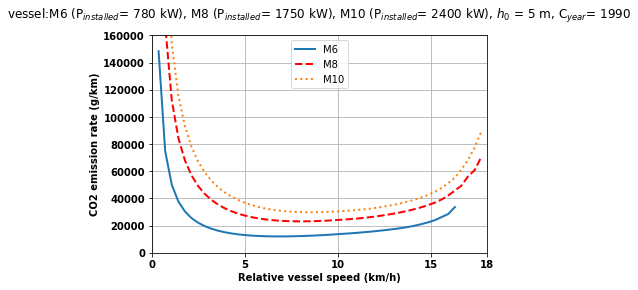

In [15]:
plt.figure(figsize=(6,4))
# Select data for this subplot/line
chosen = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot_M6 < P_installed_M6')
plt.plot(chosen['V_s_km'], chosen['emission_g_km_CO2_M6'],linewidth = 2.0)

# Select data for this subplot/line
chosen = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot_M8 < P_installed_M8')
plt.plot(chosen['V_s_km'], chosen['emission_g_km_CO2_M8'], 'r--',linewidth = 2.0)

# Select data for this subplot/line
chosen = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot_M10 < P_installed_M10')
plt.plot(chosen['V_s_km'], chosen['emission_g_km_CO2_M10'], ':',linewidth = 2.0)



plt.legend(['M6', 'M8', 'M10'],loc='upper center')
plt.grid()
plt.xlim(0, 18)  #  set vessel speed range (km/h) for inland shipping
plt.ylim(0, 160000)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('CO2 emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')

plt.title('vessel:M6 (P$_{installed}$= 780 kW), M8 (P$_{installed}$= 1750 kW), M10 (P$_{installed}$= 2400 kW), $h_0$ = 5 m, C$_{year}$= 1990',y=1.05)




-------------

### Set navigation conditions for two waterway stretches
for analysing current influence to emissions

In [16]:
# specify a number of coordinate along your route (coords are: lon, lat)
coords = [
    [0,0],
    [1,0],
    [2,0]    
] 

# for each edge (between above coordinates) specify the depth (m) and current speeds
depths = [6, 6]
width = [150,150]
current_speeds = [-0.5,-1.5]  # [m/s]

# check of nr of coords and nr of depths align
assert len(coords) == len(depths) + 1, 'nr of depths does not correspond to nr of coords'

### Set sailing speed over ground per waterway stretch
for analysing current influence to emissions

Here we fix the vessel sailing speed over water as constant, 3.5 m/s, and analyze how the varition of current speed and direction impact on emissions

In [17]:
V_g_profile_up = [3,2] # [m/s] vessel sailing speed for upstream
V_g_profile_down = [4,5] # [m/s] vessel sailing speed for downstream

### Assign navigation conditions and sailing behavior to the graph

In [18]:
# create a graph 
FG = nx.DiGraph()
nodes = []
path = []

# add nodes
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

for index, coord in enumerate(coords):
    data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
    nodes.append(Node(**data_node))
    
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

# add edges
path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]

for index, edge in enumerate(path):

    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {
        "GeneralDepth": depths[index],
        "WaterwayWidth": width[index],
        "CurrentSpeed": current_speeds[index],
        "VesselSpeedToGroundProfile_upstream": V_g_profile_up[index],
        "VesselSpeedToGroundProfile_downstream": V_g_profile_down[index]
    })

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

### define sailing path on the graph

In [19]:
path_one_stretch = nx.dijkstra_path(FG, nodes[0].name, nodes[2].name)
path_up = nx.dijkstra_path(FG, nodes[0].name, nodes[2].name)
path_down = nx.dijkstra_path(FG, nodes[2].name, nodes[0].name)

### define simulation: vessel passing path

In [20]:
def run_simulation(path,**data_vessel):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    env.process(vessel.move())
    env.run()
    
    return vessel

### run simulation for the selected vessel and path

In [21]:
vessel_simulation_results = run_simulation(path = path_up, **data_vessel_M12_up)
# create an EnergyCalculation object and perform energy consumption calculation
energycalculation_upstream = opentnsim.energy.EnergyCalculation(FG, vessel_simulation_results)
energycalculation_upstream.calculate_energy_consumption()
# create dataframe from energy calculation computation
df_results = pd.DataFrame.from_dict(energycalculation_upstream.energy_use)
selected = ['edge_start','edge_stop','distance','sailing_duration','R_tot','P_tot','total_energy',
            'total_emission_CO2','total_emission_PM10','total_emission_NOX']
            
df_results_M12_up= df_results[selected]
df_results_M12_up

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,edge_start,edge_stop,distance,sailing_duration,R_tot,P_tot,total_energy,total_emission_CO2,total_emission_PM10,total_emission_NOX
0,POINT (0 0),POINT (1 0),111319.490793,37106.496931,64.665526,753.218462,7763.694045,5.700268e+06,2606.602226,77326.130224
1,POINT (1 0),POINT (2 0),111319.490793,55659.745395,64.665526,753.218462,11645.541067,8.550402e+06,3909.903340,115989.195332


In [22]:
vessel_simulation_results = run_simulation(path = path_down, **data_vessel_M12_down)
# create an EnergyCalculation object and perform energy consumption calculation
energycalculation_upstream = opentnsim.energy.EnergyCalculation(FG, vessel_simulation_results)
energycalculation_upstream.calculate_energy_consumption()
# create dataframe from energy calculation computation
df_results = pd.DataFrame.from_dict(energycalculation_upstream.energy_use)
selected = ['edge_start','edge_stop','distance','sailing_duration','R_tot','P_tot','total_energy',
            'total_emission_CO2','total_emission_PM10','total_emission_NOX']
            
df_results_M12_down= df_results[selected]
df_results_M12_down

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,edge_start,edge_stop,distance,sailing_duration,R_tot,P_tot,total_energy,total_emission_CO2,total_emission_PM10,total_emission_NOX
0,POINT (2 0),POINT (1 0),111319.490793,22263.898159,64.665526,753.218462,4658.216427,3.420161e+06,1563.961336,46395.678134
1,POINT (1 0),POINT (0 0),111319.490793,27829.872698,64.665526,753.218462,5822.770533,4.275201e+06,1954.951670,57994.597666
